In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%201%20-%20Lesson%203%20-%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Load Package and Data

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.4.1


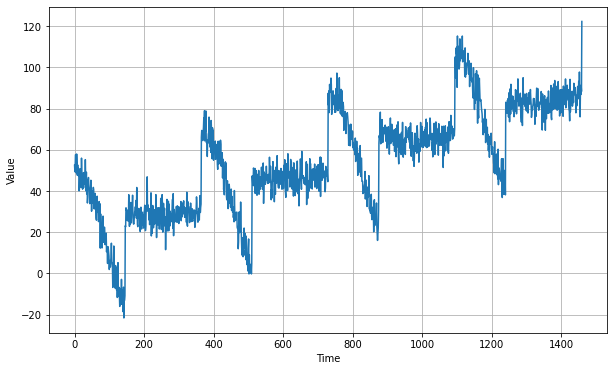

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

#2.Split Time-Series Data

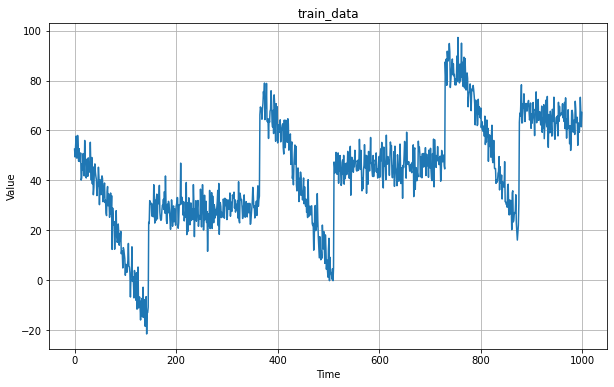

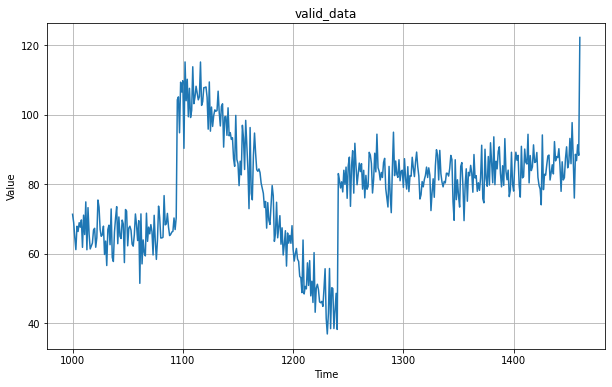

In [ ]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.title("train_data")
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.title("valid_data")
plt.show()

#3.Naive Forecast 
## - forcast the valid data after split_time ONLY
## - data at "ONE time unit" before is the final forcast 

In [ ]:
naive_forecast = series[split_time-1:-1]

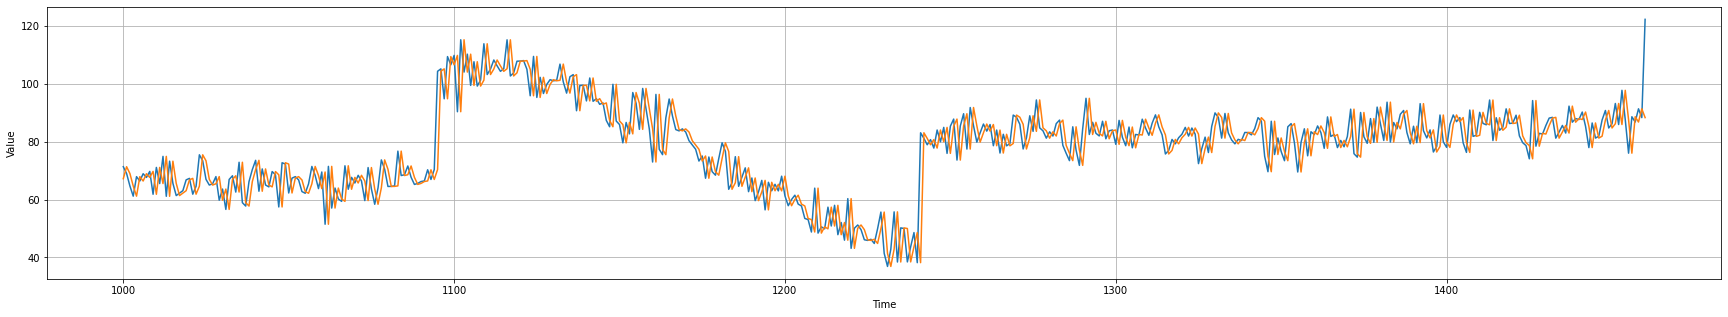

In [ ]:
plt.figure(figsize=(30, 5))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

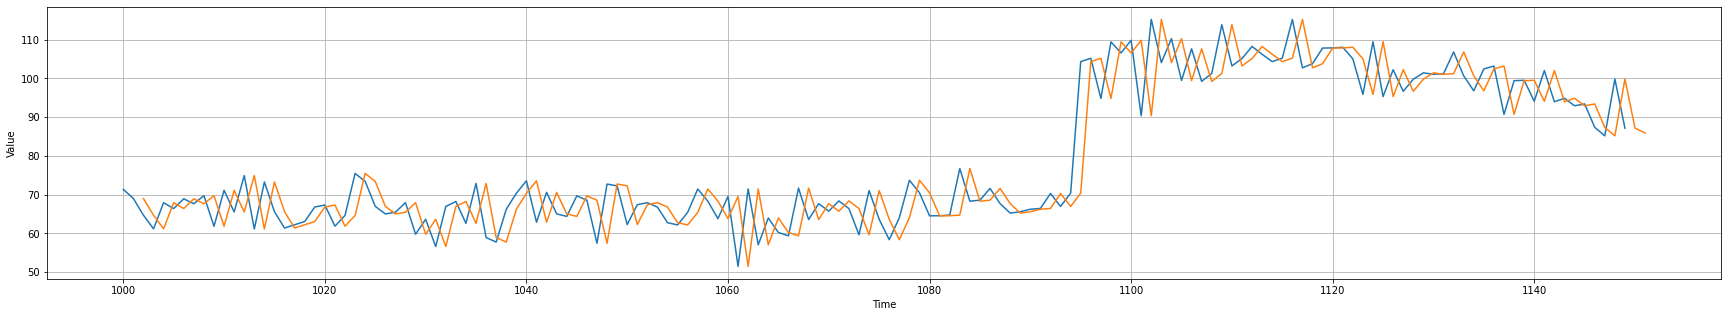

In [ ]:
"""zoom the plot with 2 unit delay"""
plt.figure(figsize=(30, 5))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=2, end=152)

In [ ]:
print(f'MSE: {keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()}')
print(f'MAE: {keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()}')

MSE: 61.82753372192383
MAE: 5.93790864944458


#4.Moving Average Focasting (MAF)
- use complete series data to do forcasting and cut the validation part for output

##4.1 Calculate Moving Average:

In [ ]:
"""calc moving average across whole series data"""
window_size=10
moving_avg = []
for time_point in range(len(series)-window_size):
  moving_avg.append(series[time_point : time_point+window_size].mean())
moving_avg = np.array(moving_avg)

moving_avg.shape # time_line: 0 -> 1451

(1451,)

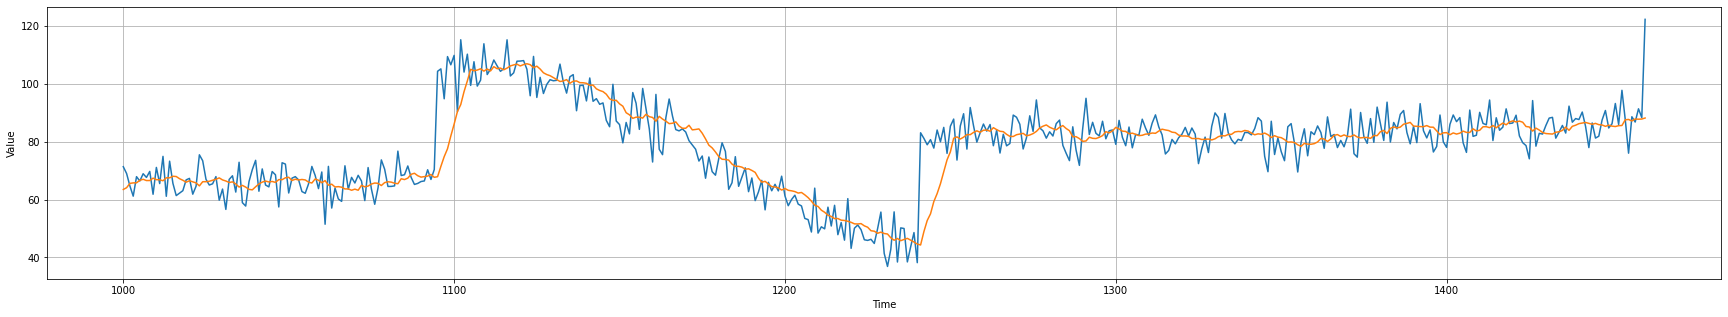

In [ ]:
"""plot the validation data for forcasting"""
plt.figure(figsize=(30, 5))
plot_series(time_valid, x_valid)                              # time_line: 1000 -> 1461
plot_series(time_valid, moving_avg[split_time-window_size:])  # time_line: 1000-window_size -> 1451

In [ ]:
print(f'MSE: {keras.metrics.mean_squared_error(x_valid, moving_avg[split_time-window_size:]).numpy()}')
print(f'MAE: {keras.metrics.mean_absolute_error(x_valid, moving_avg[split_time-window_size:]).numpy()}')

MSE: 54.032283782958984
MAE: 5.109333038330078


##4.2 Caculate Differencing
- differencing is across the whole series
- also this differencing will be added across the whole series data

In [ ]:
"""calc lag differencing to remove trend and seasonality"""
interval=365;
lag_series=[]
for time_point in range(interval, len(series)):
  lag_series.append(series[time_point]-series[time_point-interval])     # time_line: interval -> len(series) such as 365 -> 1461
lag_series = np.array(lag_series)

lag_series.shape

(1096,)

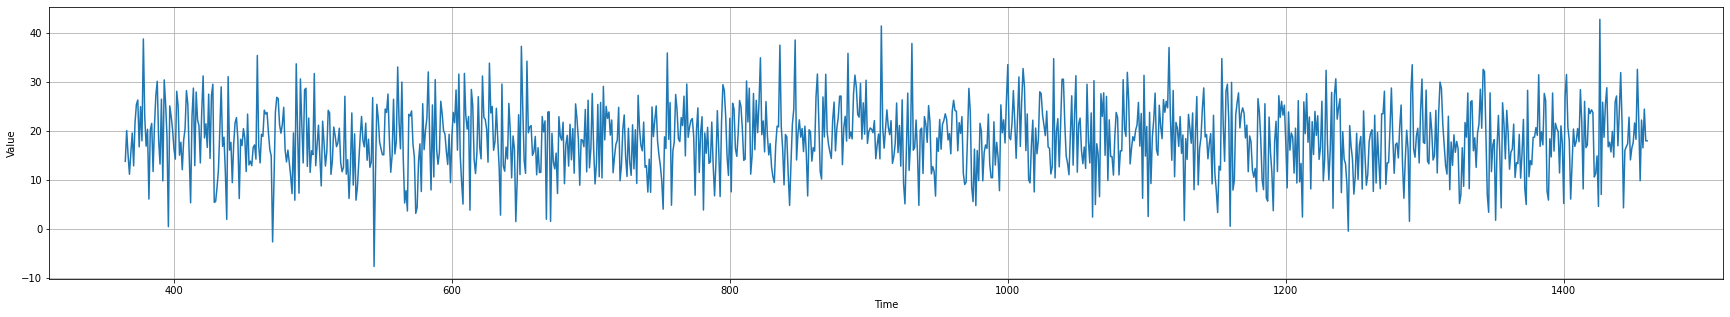

In [ ]:
"""differencing plot across the whole series"""
diff_series = np.array(lag_series)
diff_time = time[interval:]
plt.figure(figsize=(30, 5))
plot_series(time[interval:], diff_series)
plt.show()

##4.3 Calculate Moving Average on Differencing
- this calculation is across the whole differencing data with a specific window size

In [ ]:
"""calc diff_seres_avg"""
window_size=50
diff_moving_avg=[]
for time_point in range(len(diff_series)-window_size):                              # time_line: 365 -> 1461 - window_size => 365 -> 1411, totally 1046 time points
  diff_moving_avg.append(diff_series[time_point: time_point+window_size].mean())

diff_moving_avg = np.array(diff_moving_avg)
diff_moving_avg.shape

(1046,)

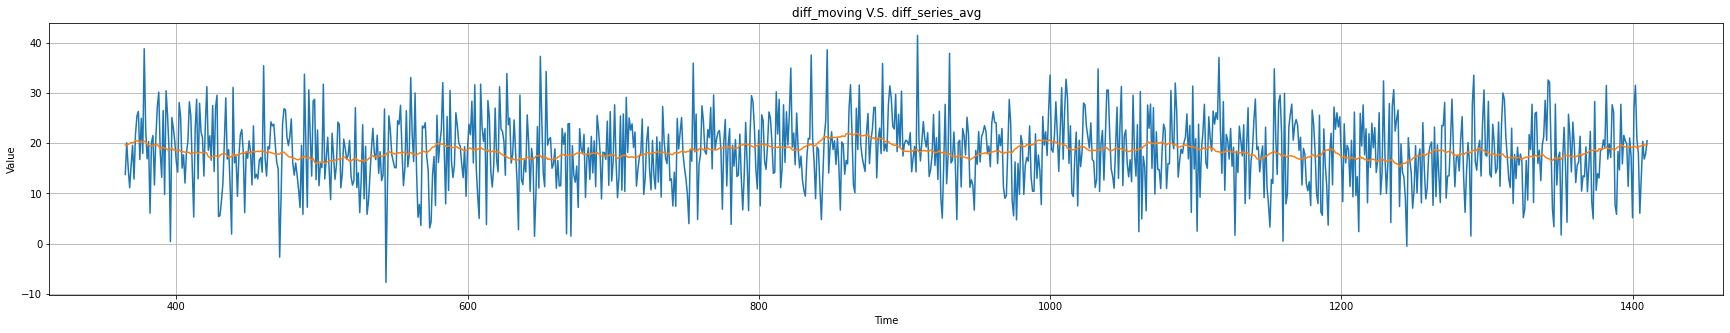

In [ ]:
"""diff_series V.S. diff_series_avg"""
plt.figure(figsize=(30, 5))
plot_series(time[interval:-window_size], diff_series[:-window_size])
plot_series(time[interval:-window_size], diff_moving_avg)
plt.title("diff_moving V.S. diff_series_avg")
plt.show()

##4.4 Calculate Moving Average with Differencing Plust Past Data
- Put avg diff on top of the t-delta_t to get the prediction across whole series
- d(t) = diff_avg(t) + d(t-delta_t)
- diff_avg(t) time_line: 365 <-> 1411 = 1046
- d(t-delta_t) time_line: 365 <-> 1406 = 1406
- so d(t) cannot be same length d(t-delta_t), so this equation can only be used for prediction of the validation_dataset
- time_valid: 1000->1406

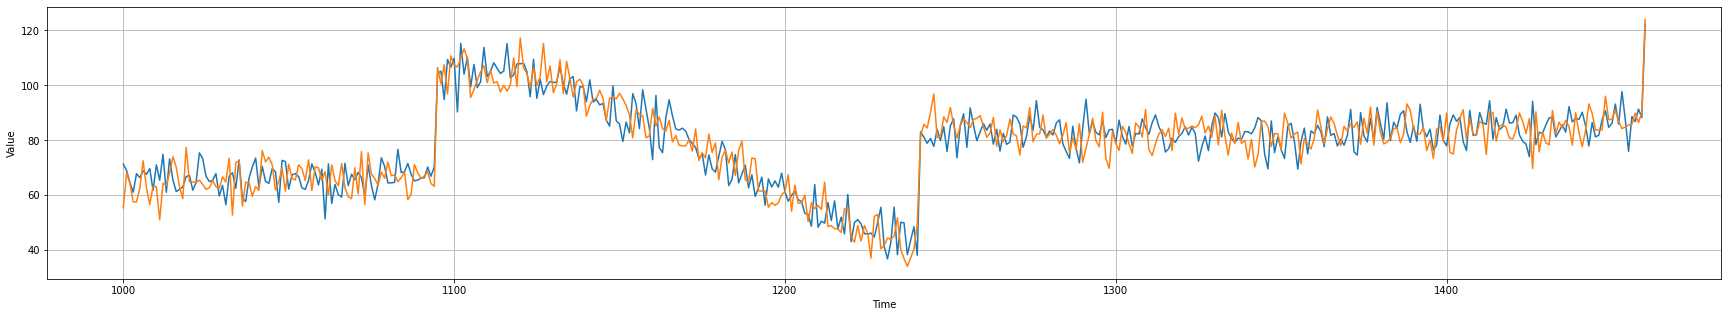

In [ ]:
"""time_valid data forcasting"""
diff_moving_forcast=[]
for time_point in time_valid:
  diff_moving_forcast.append(diff_moving_avg[int(time_point)-interval-window_size]+series[int(time_point)-interval])
diff_moving_forcast = np.array(diff_moving_forcast)

plt.figure(figsize=(30, 5))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_forcast)
plt.show()

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_forcast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_forcast).numpy())

52.97366
5.8393106


## 4.5 Calculate Moving Average With Differencing Plus Past Data With Moving Average

In [ ]:
"""calculate moving avg on the past data of the valid time ONLY, so past_time is where the data gets processed"""
window_size_pre=10
interval=360
past_time = series[split_time-interval-window_size_pre:-interval]
move_avg_past=[]
for index in range(len(past_time)-window_size_pre):
  move_avg_past.append(past_time[index:index+window_size_pre].mean())
move_avg_past = np.array(move_avg_past)
move_avg_past.shape

(461,)

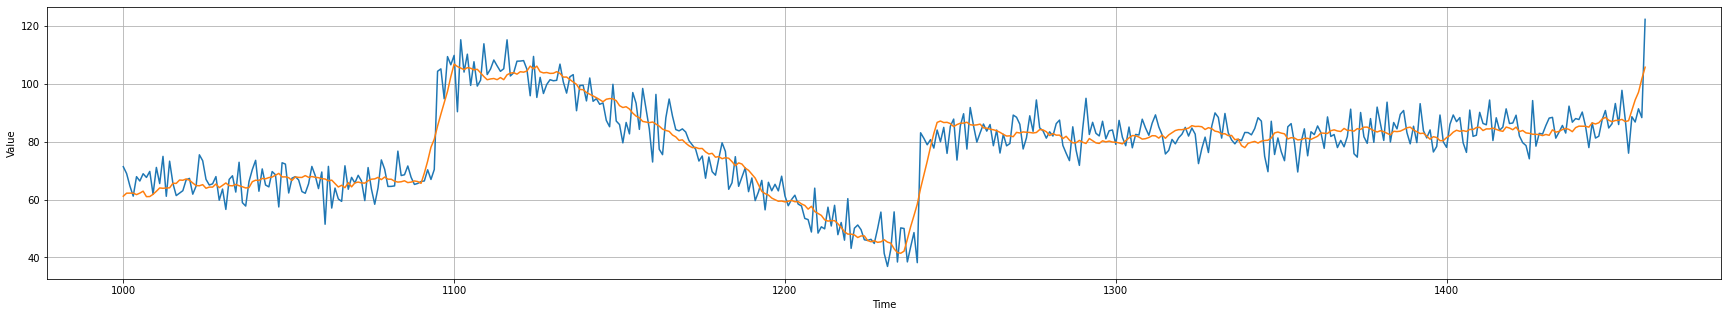

In [ ]:
"""forcast the valid time data"""
move_avg_diff_forcast = diff_moving_avg[split_time-365-window_size:]+move_avg_past

plt.figure(figsize=(30, 5))
plot_series(time_valid, x_valid)
plot_series(time_valid, move_avg_diff_forcast)
plt.show()

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, move_avg_diff_forcast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, move_avg_diff_forcast).numpy())

33.452267
4.569442
